# ML Foreclosure Binary Classification - EPOCH 2 data

    target = zeroBalCode (set to object dtype) 
    Binary classification sets zeroBalCode to either "0" or "1" for the 7 possible outcomes
    
    "0" = "Loan Success"
        * 01 = Prepaid or Matured

    "1" =  "Loan Failure" - Most likely loss of money (but not necessarily) one of below conditions:
        * 02 = Third Party Sale
        * 03 = Short Sale
        * 06 = Repurchased
        * 09 = Deed-in-Lieu,REO
        * 15 = Note Sale
        * 16 = Reperforming Loan Sale

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#!pip install pycaret
from imblearn.over_sampling import RandomOverSampler
from pycaret.classification import *
#from pycaret.regression import *

# Importing the data - only use *.ML.csv files!!!
If you have *.MLReady.csv then [click here](#MLReady)

In [2]:
df=pd.read_csv("../../data/FM_Acq_Perf_FMAC_EPOCH2_ML.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,numBorrowers,...,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct
0,1133339,1133339,100209956357,2,5.125,348000,2009-02-01,2009-04-01,87.0,1.0,...,5.04,5.13,0.041667,2.87,-0.125,-0.085,-0.005,-0.023810,-0.016865,-0.000975
1,1133340,1133340,100392775700,3,4.625,195000,2009-02-01,2009-04-01,52.0,2.0,...,5.04,5.13,0.041667,2.87,-0.625,0.415,-0.505,-0.119048,0.082341,-0.098441
2,1133341,1133341,100621428854,2,4.875,342000,2009-02-01,2009-04-01,80.0,1.0,...,5.04,5.13,0.041667,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708
3,1133342,1133342,100720959726,1,5.375,93000,2009-02-01,2009-05-01,70.0,1.0,...,5.04,5.13,0.041667,2.87,0.125,-0.335,0.245,0.023810,-0.066468,0.047758
4,1133343,1133343,100783704799,1,4.875,182000,2009-02-01,2009-04-01,76.0,2.0,...,5.04,5.13,0.041667,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708


## Remove columns not involved in 'Foreclosure or Not' query

In [4]:
df.drop(['Unnamed: 0','Unnamed: 0.1','id','firstPmtDate','rptPeriod','currIntRate','currUPB','loanAge','monMatur',\
         'zeroBalDate','lastPdInstDate','forecloDate','dispDate','forecloCost','propRepCost','recovCosts',\
         'miscCost','holdTaxCost','saleProceed','credEnhProceed','repurchProceed','otherForecloProceed',\
         'nonIntUPB','prinForgivBal','repurchMakeWholeProceedFlg','forecloPrinWriteOffAmnt','servActivIndicator',\
         'deliqGood','deliqBad','deliqMax'],1,inplace=True)

## Engineer originDate into Date features

In [6]:
df['origDate'] = pd.to_datetime(df['origDate'])

In [7]:
df['origYear'] = df['origDate'].dt.year
df['origMonth'] = df['origDate'].dt.month

In [8]:
df.drop(['origDate'],1,inplace=True)

In [9]:
df[['origYear','origMonth']].head()

,origYear,origMonth
0,2009,2
1,2009,2
2,2009,2
3,2009,2
4,2009,2


# Turn zero Balance Code Into binary "0" GOOD and "1" BAD

In [10]:
df.zeroBalCode.unique()

array([ 9.,  1.,  3., 16.,  6.,  2., 15.])

In [11]:
df['zeroBalCode'] = df.zeroBalCode.replace(1,0)
df['zeroBalCode'] = df.zeroBalCode.replace([9,3,16,6,2,15],1)

In [12]:
df.zeroBalCode.unique()

array([1., 0.])

In [13]:
#Checking datatypes of individual feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 31 columns):
origChannel           119696 non-null int64
origIntRate           119696 non-null float64
origUPB               119696 non-null int64
origLTV               119696 non-null float64
numBorrowers          119696 non-null float64
origDebtIncRatio      119696 non-null float64
borrCreditScore       119696 non-null float64
loanPurp              119696 non-null int64
zipCode               119696 non-null int64
pMIperct              119696 non-null float64
mortInsType           119696 non-null float64
bestCreditScore       119696 non-null float64
worstCreditScore      119696 non-null float64
avgCreditScore        119696 non-null float64
bankNumber            119696 non-null int64
stateNumber           119696 non-null int64
mSA                   119696 non-null int64
zeroBalCode           119696 non-null float64
fmacRateMax           119696 non-null float64
fmacRateMin           119696 

# Review values for dates and slice (if needed) the timeframe you want

In [14]:
df.origYear.unique()

array([2009, 2010, 2011, 2012, 2013], dtype=int64)

In [15]:
df['origMonth'].unique()

array([ 2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12,  1], dtype=int64)

# Coerce the column dtype (int in this case)

In [16]:
df = df.astype({'origLTV':'int','numBorrowers':'int','origDebtIncRatio':'int',\
               'borrCreditScore':'int','mortInsType':'int','bestCreditScore':'int',\
               'worstCreditScore':'int','avgCreditScore':'int','zeroBalCode':'int'})
#,'zeroBalCode':'int'

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 31 columns):
origChannel           119696 non-null int64
origIntRate           119696 non-null float64
origUPB               119696 non-null int64
origLTV               119696 non-null int32
numBorrowers          119696 non-null int32
origDebtIncRatio      119696 non-null int32
borrCreditScore       119696 non-null int32
loanPurp              119696 non-null int64
zipCode               119696 non-null int64
pMIperct              119696 non-null float64
mortInsType           119696 non-null int32
bestCreditScore       119696 non-null int32
worstCreditScore      119696 non-null int32
avgCreditScore        119696 non-null int32
bankNumber            119696 non-null int64
stateNumber           119696 non-null int64
mSA                   119696 non-null int64
zeroBalCode           119696 non-null int32
fmacRateMax           119696 non-null float64
fmacRateMin           119696 non-null float64
f

<a id='MLReady'></a>

<a id='MLReady'></a>
## *MLReady.csv file loading point
uncomment one of the boxes below

In [18]:
#df.to_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

In [19]:
#df = pd.read_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

# Oversampling (Since we are starting with only 6.3% of our predicted class)

In [20]:
good = df.zeroBalCode.value_counts()[0]
bad = df.zeroBalCode.value_counts()[1]
perct_bad = round(good/bad,2)
print(f'We have {perct_bad}% Foreclosures in our dataset')

We have 6.34% Foreclosures in our dataset


In [21]:
from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(
    df.drop(['zeroBalCode'], axis=1)
    , df['zeroBalCode']
    , test_size = .1
    , random_state=12
)

In [22]:
# Further split the training data into training/test
x_train, x_val, y_train, y_val = train_test_split(
    training_features
    , training_target
    , test_size = .1
    ,random_state=12
)

In [23]:
# For the training data, randomly sample 
ros = RandomOverSampler(sampling_strategy='minority')
x_train_res, y_train_res = ros.fit_sample(x_train, y_train)

In [24]:
print('#############################################')
print('Before oversampling: "Closed" crushes "Default" and causes issues:')
print(training_target.value_counts())
print('')
print('Before oversampling: "Closed" and "Default" are equal')
print(y_train_res.value_counts())

#############################################
Before oversampling: "Closed" crushes "Default" and causes issues:
0    93081
1    14645
Name: zeroBalCode, dtype: int64

Before oversampling: "Closed" and "Default" are equal
1    83757
0    83757
Name: zeroBalCode, dtype: int64


# Recombine X_train_res, y_train_res so PyCaret can deal with one df

In [25]:
y_train_res.shape

(167514,)

In [26]:
df = x_train_res.copy()

In [27]:
df['zeroBalCode'] = y_train_res

In [28]:
df.shape

(167514, 31)

# Review metrics last time before run (to have record of starting values)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167514 entries, 0 to 167513
Data columns (total 31 columns):
origChannel           167514 non-null int64
origIntRate           167514 non-null float64
origUPB               167514 non-null int64
origLTV               167514 non-null int32
numBorrowers          167514 non-null int32
origDebtIncRatio      167514 non-null int32
borrCreditScore       167514 non-null int32
loanPurp              167514 non-null int64
zipCode               167514 non-null int64
pMIperct              167514 non-null float64
mortInsType           167514 non-null int32
bestCreditScore       167514 non-null int32
worstCreditScore      167514 non-null int32
avgCreditScore        167514 non-null int32
bankNumber            167514 non-null int64
stateNumber           167514 non-null int64
mSA                   167514 non-null int64
fmacRateMax           167514 non-null float64
fmacRateMin           167514 non-null float64
fmacRateAvg           167514 non-null float64

In [ ]:
df.drop(['borrCreditScore', 'bestCreditScore', 'fmacRateMax', 'fmacRateMin', 'fmacRateVolatility', 'rateDiffAbove', 'rateDiffBelow',
        ''])

In [30]:
df.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,...,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode
0,3,4.625,139000,77,2,36,786,2,972,0.0,...,2.68,-0.245,0.155,-0.1850,-0.050308,0.032427,-0.038462,2009,4,0
1,2,4.375,398000,70,2,42,712,2,917,0.0,...,2.58,0.005,-0.055,0.0290,0.001144,-0.012731,0.006673,2010,9,0
2,1,4.500,730000,59,2,43,672,2,928,0.0,...,3.30,-0.300,0.210,-0.2550,-0.062500,0.044586,-0.053628,2011,1,0
3,1,4.500,96000,60,1,42,632,1,973,0.0,...,3.30,-0.300,0.210,-0.2550,-0.062500,0.044586,-0.053628,2011,1,0
4,1,3.875,111000,85,1,40,669,2,843,12.0,...,2.01,-0.125,0.105,-0.1175,-0.031250,0.026382,-0.029430,2011,11,1


In [32]:
df.to_csv('../../data/oversampledSet.csv')

# Pycaret - Setup with categorical definition

### Use complex setup 

In [33]:
model_setup = setup(
    df
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    , ignore_low_variance = True # Variance is calculated using the ratio of unique values to the number of samples, and the ratio of the most common value to the frequency of the second most common value.
    , normalize = True
    , ignore_features = None
    , handle_unknown_categorical = True
    , remove_outliers = True # outliers from the training data are removed using PCA linear dimensionality reduction using the Singular Value Decomposition technique.
    , bin_numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
        ] # Set to True to bin numerics using K Means
    , feature_selection = True
    , silent = True
    , profile = False
    , categorical_features = [
            'origChannel'
            , 'numBorrowers'
            , 'loanPurp'
            , 'zipCode'
            , 'bankNumber'
            , 'stateNumber'
            , 'origYear'
            , 'origMonth'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
        ]
)


IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:51:08
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


KeyboardInterrupt: 

## Compare Models with no blacklist exclusions

In [46]:
model_results=compare_models() #blacklist = ['tr','ransac'],'lar','par','huber','llar','lasso','en','ridge','omp','br','svm'])
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9098,0.9696,0.9117,0.9078,0.9097,0.8196
1,Random Forest Classifier,0.8784,0.9488,0.9007,0.8617,0.8807,0.7568
2,Decision Tree Classifier,0.8389,0.8392,0.9292,0.7866,0.8519,0.678
3,CatBoost Classifier,0.7631,0.8403,0.8158,0.7372,0.7745,0.5263
4,Light Gradient Boosting Machine,0.7449,0.8206,0.8023,0.7189,0.7583,0.49
5,Logistic Regression,0.7295,0.8041,0.7613,0.7148,0.7373,0.459
6,Ridge Classifier,0.7278,0,0.7661,0.7107,0.7373,0.4557
7,Linear Discriminant Analysis,0.7278,0.8028,0.7658,0.7108,0.7372,0.4556
8,SVM - Linear Kernel,0.7272,0,0.7875,0.7025,0.7421,0.4545
9,Gradient Boosting Classifier,0.717,0.787,0.757,0.7001,0.7274,0.4342


## Create models 

#### Light GBM

In [48]:
et = create_model('et', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9176,0.9708,0.9197,0.9154,0.9175,0.8352
1,0.9068,0.9695,0.9096,0.9041,0.9069,0.8136
2,0.9113,0.9697,0.9154,0.9076,0.9115,0.8226
3,0.9074,0.9684,0.9050,0.9089,0.9069,0.8147
4,0.9131,0.9709,0.9172,0.9094,0.9133,0.8262
5,0.9102,0.9681,0.9057,0.9136,0.9096,0.8205
6,0.9031,0.9678,0.9057,0.9005,0.9031,0.8061
7,0.9045,0.9684,0.9053,0.9034,0.9044,0.8090
8,0.9086,0.9703,0.9157,0.9024,0.9090,0.8172
9,0.9152,0.9726,0.9179,0.9126,0.9153,0.8305


#### CatBoost

In [ ]:
#catboost =create_model('catboost', fold = 10)

#### XGBoost

In [ ]:
#xgboost = create_model('xgboost', fold = 10)

## Tune Models

#### CatBoost

In [49]:
#tuned_catboost = tune_model('catboost') # from fold=50

### CatBoost had mixed improvements / declines 
#### Improved:  Accuracy    Precision
#### Declined: AUC   Recall    F1   Kappa
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Tuned:    Mean	0.8653	0.7916	0.0385	0.5872	0.0723	0.0564

#### Light GBM

In [50]:
#tuned_lightgbm = tune_model('lightgbm')

### LightGBM had mixed improvements / declines 
#### Improved:  Accuracy    Precision
#### Declined: AUC   Recall    F1   Kappa
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Tuned:    Mean	0.8663	0.7918	0.0691	0.5780	0.1234	0.0972

#### XGBoost

In [ ]:
#tuned_xgboost = tune_model('xgboost')

Didn't tune xgboost since it takes about 5 hours and I don't see a big benefit tuning the above models

## Ensemble models

In [ ]:
#catboost_bagged = ensemble_model(catboost)

### CatBoost had great improvements with Ensemble Bagging
#### Improved:  Accuracy   AUC   Recall   F1   Kappa
#### Declined:   Precision    
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Bagging:  Mean	0.8664	0.7972	0.0837	0.5637	0.1456	0.1145

In [ ]:
#catboost_boosted = ensemble_model(catboost)

## Blend 3 chosen Models

#### First blend 'non-tuned' models

In [ ]:
#blend3 = blend_models(estimator_list = [catboost, lightgbm, xgboost])

#### Next blend tuned models

In [ ]:
#blendTuned3 = blend_models(estimator_list = [tuned_catboost, tuned_lightgbm, tuned_xgboost])

## Evaluate Models

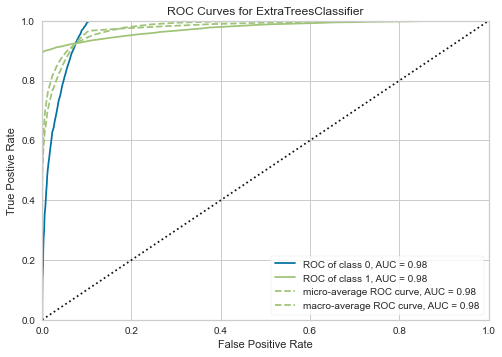

In [51]:
plot_model(et)

In [ ]:
plot_model(et, plot = 'threshold')

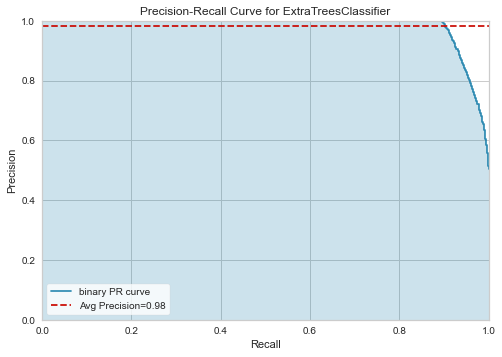

In [52]:
plot_model(et, plot = 'pr')

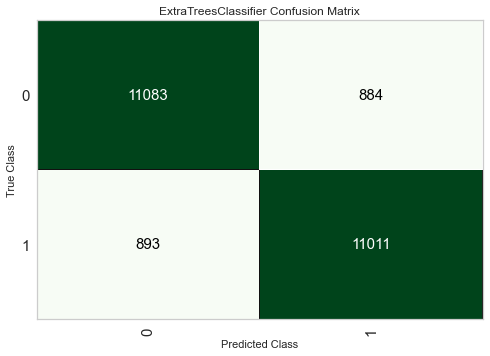

In [53]:
plot_model(et, plot='confusion_matrix')

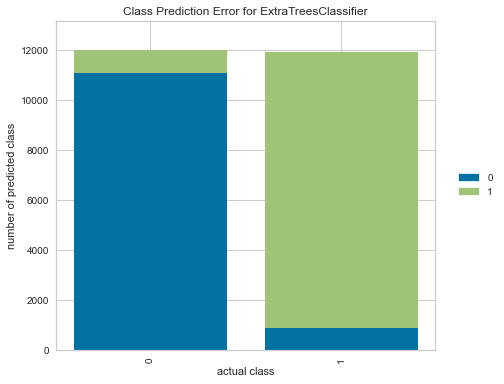

In [54]:
plot_model(et, plot = 'error')

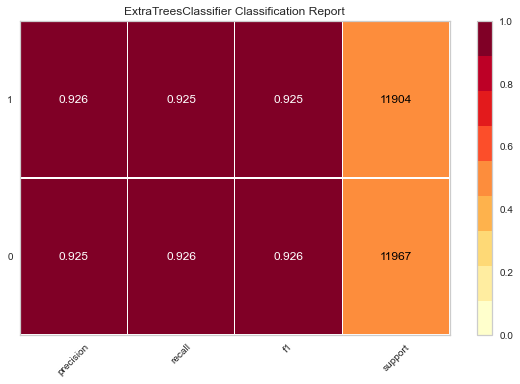

In [55]:
plot_model(et, plot = 'class_report')

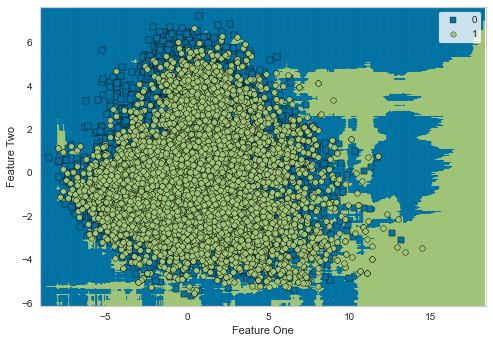

In [56]:
plot_model(et, plot = 'boundary')

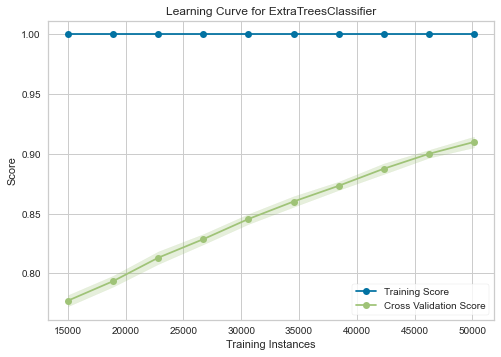

In [71]:
plot_model(et, plot='learning')

In [ ]:
plot_model(et, plot = 'manifold')

IntProgress(value=0, description='Processing: ', max=5)

In [ ]:
plot_model(et, plot = 'calibration')

In [ ]:
plot_model(et, plot = 'vc')

In [ ]:
plot_model(et, plot='dimension')

In [ ]:
plot_model(et, plot = 'feature')

In [ ]:
plot_model(et, plot = 'parameter')

# Interpret Models

## Extra Tree Classifier (et)

In [ ]:
interpret_model(et plot = 'summary')

In [ ]:
#interpret_model(et, plot='correlation', feature='avgCreditScore')

# Predict models

In [57]:
pred_holdout = predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9256,0.9756,0.925,0.9257,0.9253,0.8511


# Recombine X_test_res, y_test_res so PyCaret can deal with one df

In [58]:
test_target.shape

(11970,)

In [59]:
df = training_features.copy()

In [60]:
df['zeroBalCode'] = test_target

In [61]:
df.shape

(107726, 31)

# The golden moment... put 10% sample test data through the model...

In [64]:
predictions = predict_model(et, data=df)

In [ ]:
pd.set_option('max_columns',None)
predictions.tail()

In [68]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107726 entries, 0 to 107725
Data columns (total 33 columns):
origChannel           107726 non-null int64
origIntRate           107726 non-null float64
origUPB               107726 non-null int64
origLTV               107726 non-null int32
numBorrowers          107726 non-null int32
origDebtIncRatio      107726 non-null int32
borrCreditScore       107726 non-null int32
loanPurp              107726 non-null int64
zipCode               107726 non-null int64
pMIperct              107726 non-null float64
mortInsType           107726 non-null int32
bestCreditScore       107726 non-null int32
worstCreditScore      107726 non-null int32
avgCreditScore        107726 non-null int32
bankNumber            107726 non-null int64
stateNumber           107726 non-null int64
mSA                   107726 non-null int64
fmacRateMax           107726 non-null float64
fmacRateMin           107726 non-null float64
fmacRateAvg           107726 non-null float64

In [70]:
save_model(et, 'et_EPOCH2_Over50_50_052320')

Transformation Pipeline and Model Succesfully Saved
